# Louvain

In [1]:
import ast
import collections
import json
import math
import os
import re
from collections import Counter

import community as community_louvain
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from dotenv import find_dotenv, load_dotenv
from infomap import Infomap
from networkx.algorithms.cuts import conductance

* **Louvain** is a **community detection algorithm** introduced by Blondel et al. (2008).
* Instead of focusing on information flow (like Infomap), it optimizes **modularity**:

  * Modularity measures how well a partition separates a network into dense **intra-community connections** with sparse **inter-community connections**.
  * A high modularity means that most edges fall inside communities rather than between them.
  * Louvain’s goal: find the partition that **maximizes modularity**.

---

**Key Features**

* **Fast & Scalable**: Works on graphs with **millions of nodes and edges**.
* **Hierarchical**: Builds a hierarchy of communities (coarse → fine).
* **Unsupervised**: No prior knowledge of number or size of communities required.
* **Widely used**: Standard baseline for community detection in network science.

---

**How It Works (Conceptually)**

1. **Local Modularity Optimization**

   * Start with each node in its own community.
   * For each node, check if moving it to a neighbor’s community **increases modularity**.
   * Move the node if beneficial; repeat until no single-node move improves modularity.

2. **Community Aggregation**

   * Collapse the graph: each community becomes a “super-node.”
   * Edges between communities are weighted by total connections.

3. **Iterative Refinement**

   * Repeat steps 1–2 until modularity gain is negligible.
   * The result is a hierarchy: fine-grained communities at lower levels, coarse ones at higher levels.

---

* *“Where are the edges densest relative to chance?”*
* That density = a community.

---


## Dataset NQ version 0

In [2]:
df = pd.read_csv("../data/v0.0/df_nq_version0.csv")
df

,id,d_properties_document_title,d_properties_title_encode,cites_ids
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ..."
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156..."
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1..."
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,..."
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123..."
...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001..."
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452..."
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]"
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708..."


In [3]:
def create_test_graph():
    """Create test graph with metadata."""

    # Convert stringified lists into real Python lists
    df["cites_ids"] = df["cites_ids"].apply(ast.literal_eval)

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph
    for _, row in df.iterrows():
        src = row["id"]
        G.add_node(src, title=row["d_properties_document_title"])
        for tgt in row["cites_ids"]:
            G.add_edge(src, tgt)

    # Graph metadata for reporting
    graph_info = {
        "source": "NQ (Natural Questions) from Google",
        "description": "Graph constructed from wiki articles citation data in the Natural Questions dataset"
    }

    return G, graph_info

G, graph_info = create_test_graph()

## Implementation

In [11]:
# IDs
id_set = set(df["id"].tolist())
max(id_set)

109711

In [12]:
# Create mapping from original IDs to consecutive integers
# original ID → 0-based index
id_to_index = {node_id: idx for idx, node_id in enumerate(sorted(id_set))}
# 0-based index → original ID
index_to_id = {idx: node_id for node_id, idx in id_to_index.items()}

In [14]:
# Build graph using igraph with proper indexing
edges = []
edge_weights = {}  # Use dictionary to aggregate weights

for src, cites in zip(df["id"], df["cites_ids"]):
    for tgt in cites:
        if tgt in id_set and tgt != src:
            # Convert original IDs to consecutive indices
            src_idx = id_to_index[src]
            tgt_idx = id_to_index[tgt]

            # Create canonical edge representation
            u, v = min(src_idx, tgt_idx), max(src_idx, tgt_idx)
            edges.append((u, v))

            # Aggregate weights by counting occurrences
            edge_key = (u, v)
            edge_weights[edge_key] = edge_weights.get(edge_key, 0) + 1

# Create igraph with proper number of vertices
n_nodes = len(id_set)
g = ig.Graph(n_nodes)

# Add edges
g.add_edges(edges)

print('Number of nodes:', n_nodes)
print('Number of edges:', len(edges))

Number of nodes: 108071
Number of edges: 5122983


In [16]:
# Add weights to the graph
if edge_weights:
    weight_list = []
    for edge in g.es:
        u = edge.source
        v = edge.target
        edge_key = (min(u, v), max(u, v))
        weight_list.append(edge_weights.get(edge_key, 1))
    g.es['weight'] = weight_list

    weights = g.es['weight']
    print("Weight summary:")
    print("Number of edges:", len(weights))
    print("Unique values:", np.unique(weights))
    print("Max:", np.max(weights))
    print("Min:", np.min(weights))

Weight summary:
Number of edges: 5122983
Unique values: [1 2]
Max: 2
Min: 1


In [25]:
# Run Louvain with igraph
print("Running Louvain community detection...")

# partition = g.community_multilevel(weights='weight', random_state=11)

best = None
best_mod = float("-inf")

for s in range(10):
    part = g.community_multilevel(weights="weight")
    mod = part.modularity  # uses g.es["weight"] by default if present
    if mod > best_mod:
        best, best_mod = part, mod

partition = best

Running Louvain community detection...


In [26]:
# Extract community assignments
community_assignments = {}
for community_id, community in enumerate(partition):
    for node_idx in community:
        # Convert back to original ID
        original_id = index_to_id[node_idx]
        community_assignments[original_id] = community_id

# Add community column to DataFrame
print("Adding community assignments to DataFrame...")
df['community'] = df['id'].map(community_assignments)

# For any nodes not found in communities (shouldn't happen, but just in case)
df['community'] = df['community'].fillna(-1).astype(int)

# Save the updated DataFrame
print("Saving results...")
df.to_csv("../data/v0.0/df_nq_version0_with_communities.csv", index=False)

print("Completed!")
print(f"Found {len(partition)} communities")
print(f"Community distribution:\n{df['community'].value_counts().head()}")


Adding community assignments to DataFrame...
Saving results...
Completed!
Found 569 communities
Community distribution:
community
5    18460
3    14470
8    14370
2    13187
1    11905
Name: count, dtype: int64


In [4]:
def parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    # handles strings like "[1, 2, 3]"
    return ast.literal_eval(x)

df["cites_ids"] = df["cites_ids"].map(parse_list)

id_set = set(df["id"].tolist())

# Sanity: total nodes in dataset
n_docs = df["id"].nunique()  # expect 108_071

# Count total *raw* citations that point to docs inside the dataset
total_citations_in_set = 0
for src, cites in zip(df["id"], df["cites_ids"]):
    total_citations_in_set += sum(1 for tgt in cites if tgt in id_set and tgt != src)

print("Docs:", n_docs)
print("Total citations (directed, inside-set):", total_citations_in_set)

Docs: 108071
Total citations (directed, inside-set): 5122983


In [5]:
# DG = nx.DiGraph()
# DG.add_nodes_from(id_set)  # add isolates!

# for src, cites in zip(df["id"], df["cites_ids"]):
#     for tgt in cites:
#         if tgt in id_set and tgt != src:
#             DG.add_edge(src, tgt)

# print("DG nodes:", DG.number_of_nodes())              
# print("DG edges (unique directed):", DG.number_of_edges())

In [6]:
pair_weight = Counter()

for src, cites in zip(df["id"], df["cites_ids"]):
    for tgt in cites:
        if tgt in id_set and tgt != src:
            u, v = (src, tgt) if src < tgt else (tgt, src)  # canonical undirected key
            pair_weight[(u, v)] += 1  # counts A→B and B→A if both exist

UG = nx.Graph()
UG.add_nodes_from(id_set)  # keep isolates
UG.add_weighted_edges_from((u, v, w) for (u, v), w in pair_weight.items())

print("UG nodes:", UG.number_of_nodes())
print("UG edges (undirected):", UG.number_of_edges())

UG nodes: 108071
UG edges (undirected): 4372291


In [ ]:
partition = community_louvain.best_partition(
    UG, weight="weight", resolution=1.0, random_state=42
)

Infomap found a **hierarchical structure**:

* **Level 1 (top):** 1294 clusters (the ones you have in `community`).
* **Level 2:** Each of those may split further (802 submodules).
* **Level 3:** Eventually collapsed into 2 supermodules.
* **Level 4:** No deeper splits.


In [ ]:
# Dataset with Infomap results
nodes_infomap = df.copy()

# node_id -> cluster_id mapping
communities = {node.node_id: node.module_id for node in im.nodes}
nodes_infomap["community"] = nodes_infomap["id"].map(communities)

# Build hierarchy map: node_id -> full path tuple
hierarchy_map = {}
for node in im.tree:
    if node.is_leaf:
        hierarchy_map[node.node_id] = tuple(node.path)

# Attach full path to DataFrame
nodes_infomap["infomap_path"] = nodes_infomap["id"].map(hierarchy_map)

nodes_infomap

,id,d_properties_document_title,d_properties_title_encode,cites_ids,infomap_cluster,infomap_path
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ...",3.0,"(3, 1550)"
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156...",7.0,"(7, 1285)"
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1...",5.0,"(5, 118, 1)"
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,...",5.0,"(5, 1, 202)"
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123...",43.0,"(43, 84)"
...,...,...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001...",77.0,"(77, 299)"
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452...",7.0,"(7, 1746)"
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]",5.0,"(5, 45, 36)"
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708...",10.0,"(10, 3981)"


In [2]:
df = pd.read_csv("../data/v0.0/df_nq_version0_with_communities.csv")
df

,id,d_properties_document_title,d_properties_title_encode,cites_ids,community
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ...",0
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156...",1
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1...",2
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,...",2
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123...",1
...,...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001...",26
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452...",1
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]",2
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708...",4


## Evaluation

Conductance

* **Definition:**
  For a community $C$, conductance is:

  $$
  \phi(C) = \frac{\text{edges leaving C}}{\min(\text{volume(C)}, \text{volume(V\C)})}
  $$

  * **edges leaving C** = number of edges from nodes in C to nodes outside C.
  * **volume(C)** = total degree of nodes in C.

* **Interpretation:**

  * Low conductance = community is “well separated” from the rest of the graph.
  * High conductance = community is highly connected to other communities (less “self-contained”).

* **In citation networks:**
  
  * Conductance tells us whether a cluster is a “self-referential neighborhood” (low) vs. a “cross-disciplinary” one (high).
  * E.g. “NFL Super Bowl” cluster probably cites mostly within sports → lower conductance.
  “Mathematics” cluster might cite across sciences → higher conductance.

---

Triad Participation Ratio (TPR)

* **Definition:**
  Fraction of nodes in a community that participate in at least one **closed triad** (triangle) *within that community*.

* **Why useful:**
  Measures how much a community contains **tight-knit relationships** rather than just star-like or sparse connections.

* **In citation networks:**

  * A high TPR cluster means “dense citation neighborhoods” (topics where articles frequently cite each other).
  * A low TPR cluster means the community might actually just be “hub and spokes” around a central article, not a true “topic cluster”.

---

* **Conductance** → tests how *separable* Infomap’s communities are in your citation graph.
* **TPR** → tests how *cohesive* they are internally.

  * Good clusters: low conductance + high TPR.
  * Weak clusters: high conductance + low TPR.

In [3]:
# Build undirected graph from your citations
G_undirected = nx.Graph()
for _, row in df.iterrows():
    src = row["id"]
    for tgt in row["cites_ids"]:
        G_undirected.add_edge(src, tgt)


In [4]:
def compute_conductance(G, community_nodes):
    if len(community_nodes) == 0 or len(community_nodes) == len(G):
        return None  # not defined for empty or whole graph
    return conductance(G, community_nodes)

def compute_tpr(G, community_nodes):
    if not community_nodes:
        return 0
    subG = G.subgraph(community_nodes)
    triangles = nx.triangles(subG)  # dict: node -> number of triangles it participates in
    participating = sum(1 for t in triangles.values() if t > 0)
    return participating / len(community_nodes)

In [8]:
results = []
for cluster_id, group in df.groupby("community"):
    community_nodes = set(group["id"])
    
    phi = compute_conductance(G_undirected, community_nodes)
    tpr = compute_tpr(G_undirected, community_nodes)
    
    results.append({
        "cluster_id": cluster_id,
        "size": len(community_nodes),
        "conductance": phi,
        "TPR": tpr
    })

cluster_eval = pd.DataFrame(results)

In [9]:
print(cluster_eval.describe())
cluster_eval

       cluster_id          size  conductance    TPR
count  569.000000    569.000000        569.0  569.0
mean   284.000000    189.931459          1.0    0.0
std    164.400426   1503.426671          0.0    0.0
min      0.000000      1.000000          1.0    0.0
25%    142.000000      1.000000          1.0    0.0
50%    284.000000      1.000000          1.0    0.0
75%    426.000000      1.000000          1.0    0.0
max    568.000000  18817.000000          1.0    0.0


,cluster_id,size,conductance,TPR
0,0,4553,1.0,0.0
1,1,17645,1.0,0.0
2,2,13485,1.0,0.0
3,3,14433,1.0,0.0
4,4,18817,1.0,0.0
...,...,...,...,...
564,564,1,1.0,0.0
565,565,1,1.0,0.0
566,566,1,1.0,0.0
567,567,1,1.0,0.0


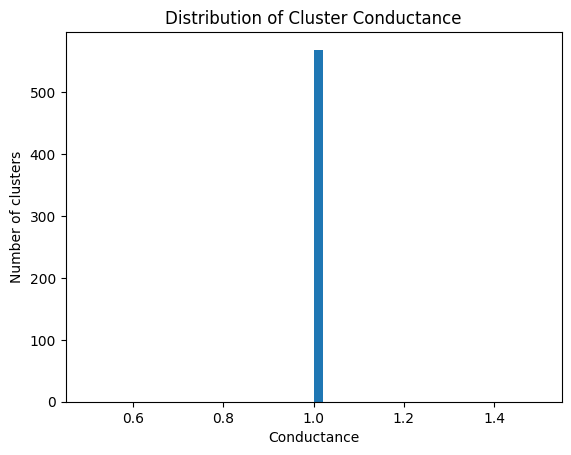

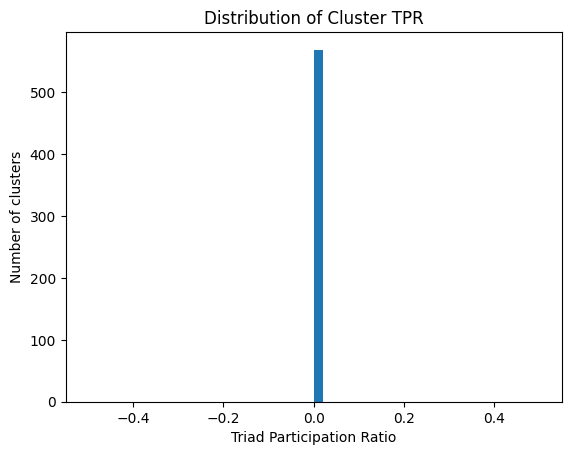

In [10]:
# Conductance distribution
plt.hist([x for x in cluster_eval["conductance"] if x is not None], bins=50)
plt.xlabel("Conductance")
plt.ylabel("Number of clusters")
plt.title("Distribution of Cluster Conductance")
plt.show()

# TPR distribution
plt.hist(cluster_eval["TPR"], bins=50)
plt.xlabel("Triad Participation Ratio")
plt.ylabel("Number of clusters")
plt.title("Distribution of Cluster TPR")
plt.show()


27


<Axes: >

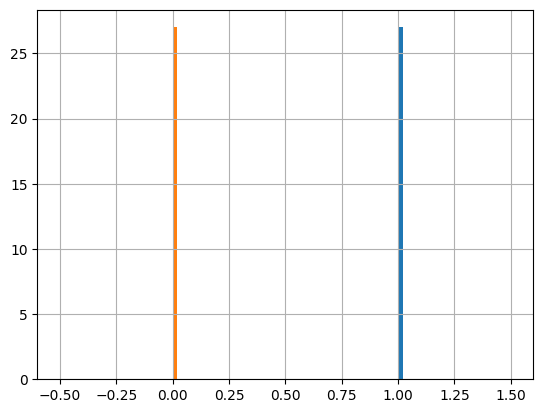

In [11]:
big_clusters = cluster_eval[cluster_eval["size"] >= 50]

print(len(big_clusters))

big_clusters["conductance"].hist(bins=50)
big_clusters["TPR"].hist(bins=50)


## Visualization

In [12]:
N_CLUSTERS = 20


Top 10 biggest clusters:
1. Cluster 4: 18817 nodes
2. Cluster 1: 17645 nodes
3. Cluster 3: 14433 nodes
4. Cluster 2: 13485 nodes
5. Cluster 6: 11077 nodes
6. Cluster 7: 5915 nodes
7. Cluster 8: 5764 nodes
8. Cluster 0: 4553 nodes
9. Cluster 14: 4132 nodes
10. Cluster 10: 3659 nodes

Top 10 smallest clusters:
1. Cluster 22: 1 nodes
2. Cluster 24: 1 nodes
3. Cluster 29: 1 nodes
4. Cluster 33: 1 nodes
5. Cluster 34: 1 nodes
6. Cluster 35: 1 nodes
7. Cluster 36: 1 nodes
8. Cluster 38: 1 nodes
9. Cluster 39: 1 nodes
10. Cluster 40: 1 nodes


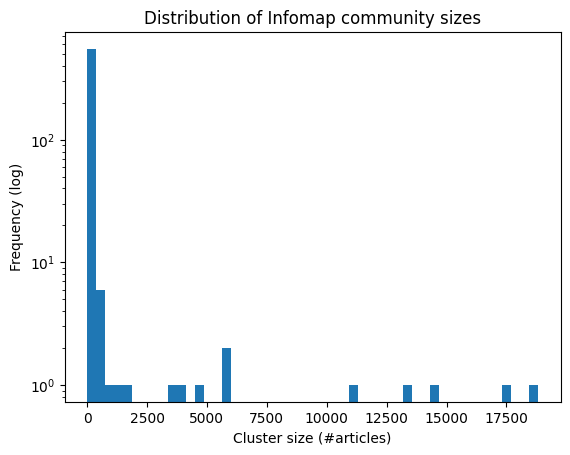

In [13]:
# Drop NaN and cast to int
clusters_clean = [
    int(c) for c in df["community"] 
    if not (isinstance(c, float) and math.isnan(c))
]

cluster_sizes = collections.Counter(clusters_clean)

def print_clusters(title, clusters):
    print(f"\n{title}")
    for i, (c, s) in enumerate(clusters, start=1):
        print(f"{i}. Cluster {c}: {s} nodes")

print_clusters("Top 10 biggest clusters:", cluster_sizes.most_common(10))
print_clusters("Top 10 smallest clusters:", sorted(cluster_sizes.items(), key=lambda x: x[1])[:10])


cluster_values = df["community"].value_counts()
plt.hist(cluster_values, bins=50, log=True)
plt.xlabel("Cluster size (#articles)")
plt.ylabel("Frequency (log)")
plt.title("Distribution of Infomap community sizes")
plt.show()

In [14]:
# Peek at titles in one cluster
cluster_id = 6
sample_titles = df[df["community"] == cluster_id]["d_properties_document_title"]
sample_titles

13              Redwood National and State Parks
24            National debt of the United States
35          List of regions of the United States
49              Commonwealth (U.S. insular area)
55                                Monkey's uncle
                           ...                  
108041                       The Literary Digest
108043                       Orleans Levee Board
108046                       Kate Spade New York
108051                   Cleveland Heights, Ohio
108060    Hazardous Materials Transportation Act
Name: d_properties_document_title, Length: 11077, dtype: object

### TOP

In [15]:
def cluster_keywords(df, cluster_id, top_n=20):
    titles = df[df["community"] == cluster_id]["d_properties_document_title"].dropna().tolist()
    words = []
    for t in titles:
        tokens = re.findall(r"[A-Za-z]+", t)  # simple word split
        words.extend([w.lower() for w in tokens if len(w) > 3])
    return Counter(words).most_common(top_n)

for i in range(1, N_CLUSTERS+1):
    print(f"Cluster {i} keywords:\n", cluster_keywords(df, i))


Cluster 1 keywords:
 [('list', 1688), ('world', 659), ('united', 506), ('history', 446), ('surname', 339), ('south', 327), ('national', 310), ('kingdom', 290), ('fifa', 241), ('football', 224), ('name', 222), ('africa', 216), ('australia', 214), ('countries', 192), ('european', 181), ('international', 180), ('union', 179), ('league', 172), ('states', 166), ('visa', 157)]
Cluster 2 keywords:
 [('song', 2412), ('love', 639), ('album', 488), ('list', 387), ('music', 319), ('your', 265), ('that', 258), ('what', 249), ('with', 212), ('band', 193), ('like', 184), ('world', 168), ('this', 164), ('time', 141), ('when', 133), ('life', 132), ('series', 129), ('from', 129), ('songs', 128), ('want', 127)]
Cluster 3 keywords:
 [('list', 391), ('history', 128), ('system', 119), ('water', 102), ('cell', 101), ('united', 100), ('energy', 94), ('human', 86), ('states', 83), ('power', 83), ('cuisine', 75), ('acid', 74), ('medical', 73), ('disease', 72), ('nuclear', 70), ('food', 70), ('health', 63), ('m

📊 Cluster Titles & Groupings

 🌍 Macrogroup 1: Geography, Nations & History

* **Cluster 1 – Global Nations & Sports**
  (list, world, united, history, surname, south, national, kingdom, fifa, football, visa, etc.)
* **Cluster 6 – United States & Regions**
  (states, united, state, york, california, texas, florida, rivers, counties, presidential, etc.)
* **Cluster 7 – India & South Asia**
  (india, indian, pakistan, cricket, pradesh, delhi, education, institute, national, etc.)
* **Cluster 9 – Canada & Olympics**
  (canada, canadian, olympics, winter, summer, ontario, hockey, medals, etc.)
* **Cluster 19 – US Law & Capital Punishment**
  (laws, executed, punishment, united, states, texas, virginia, california, ohio, etc.)

---

 🎶 Macrogroup 2: Music, Literature & Arts

* **Cluster 2 – Music & Songs**
  (song, love, album, band, music, world, songs, want, life, time, etc.)
* **Cluster 12 – Shakespeare & Literature**
  (shakespeare, romeo, juliet, sonnet, poem, tale, story, midsummer, dream, etc.)

---

 🎬 Macrogroup 3: Film, TV & Entertainment

* **Cluster 4 – Film, TV & Characters**
  (film, list, series, season, episodes, actors, show, star, novel, american, etc.)
* **Cluster 11 – Gossip Girl (TV Niche)**
  (gossip, girl, season, chuck, blair, nate, woodsen, humphrey, xoxo, etc.)
* **Cluster 13 – Anime & Manga**
  (dragon, ball, naruto, bleach, sailor moon, episodes, characters, etc.)
* **Cluster 16 – Models & TV Dramas**
  (america’s next top model, vampire diaries, originals, characters, episodes, etc.)
* **Cluster 17 – Reality TV & Food Shows**
  (housewives, bachelor, hell’s kitchen, australian shows, chefs, episodes, etc.)
* **Cluster 20 – Fantasy Films & Franchises**
  (harry potter, lord of the rings, thrones, middle-earth, characters, film, game, soundtrack, etc.)

---

 🏟️ Macrogroup 4: Sports & Games

* **Cluster 5 – Gambling, Golf & Vegas Leisure**
  (golf, vegas, casino, poker, hotel, resort, roller coaster, tournaments, etc.)
* **Cluster 14 – American Sports Leagues**
  (football, basketball, baseball, ncaa, draft, bowl, teams, leagues, university, etc.)
* **Cluster 15 – Cars & Racing**
  (ford, honda, toyota, chevrolet, engines, racing, nascar, vehicles, road, etc.)

---

 🧠 Macrogroup 5: Science, Education & Systems

* **Cluster 3 – Science & Medicine**
  (system, cell, energy, disease, nuclear, health, medical, human, food, cuisine, etc.)
* **Cluster 8 – Social Sciences & Education**
  (theory, social, education, management, economics, psychology, market, analysis, etc.)
* **Cluster 18 – Space & Astronomy**
  (space, solar, moon, mars, planets, stars, galaxy, constellations, satellites, etc.)

---

 ✝️ Macrogroup 6: Religion & Mythology

* **Cluster 10 – Christianity & Ancient Beliefs**
  (church, roman, catholic, bible, jesus, holy, mythology, saints, christianity, cathedral, etc.)

---

In [19]:
G = nx.DiGraph()
for _, row in df.iterrows():
    src_cluster = row["community"]
    for tgt in row["cites_ids"]:
        tgt_cluster = communities.get(tgt)  # lookup cluster for target
        if tgt_cluster is not None and src_cluster != tgt_cluster:
            G.add_edge(src_cluster, tgt_cluster)

# Select clusters
top_clusters = df["community"].value_counts().index[:N_CLUSTERS]

# Build subgraph of top clusters
subG = G.subgraph(top_clusters)

# Visualize
plt.figure(figsize=(10,8))
nx.draw(subG, with_labels=True, node_size=500, font_size=8)
plt.show()

NameError: name 'communities' is not defined

### BOTTOM

In [18]:
# Count how many clusters have a given small size
for k in range(20):
    count = sum(1 for size in cluster_sizes.values() if size == k)
    print(f"Number of clusters with exactly {k} nodes: {count}")


Number of clusters with exactly 0 nodes: 0
Number of clusters with exactly 1 nodes: 535
Number of clusters with exactly 2 nodes: 1
Number of clusters with exactly 3 nodes: 0
Number of clusters with exactly 4 nodes: 0
Number of clusters with exactly 5 nodes: 0
Number of clusters with exactly 6 nodes: 0
Number of clusters with exactly 7 nodes: 0
Number of clusters with exactly 8 nodes: 0
Number of clusters with exactly 9 nodes: 0
Number of clusters with exactly 10 nodes: 0
Number of clusters with exactly 11 nodes: 1
Number of clusters with exactly 12 nodes: 0
Number of clusters with exactly 13 nodes: 1
Number of clusters with exactly 14 nodes: 0
Number of clusters with exactly 15 nodes: 0
Number of clusters with exactly 16 nodes: 0
Number of clusters with exactly 17 nodes: 0
Number of clusters with exactly 18 nodes: 0
Number of clusters with exactly 19 nodes: 0


In [23]:
def get_clusters_by_size(df, size, cols=None):
    """
    Extract all clusters of a given size (e.g. 1, 2, 3...).
    """
    df = df.dropna(subset=["community"]).copy()
    df["community"] = df["community"].astype(int)

    # Count cluster sizes
    cluster_sizes = Counter(df["community"])

    # Filter clusters of given size
    target_clusters = [c for c, s in cluster_sizes.items() if s == size]

    # Extract rows
    out_df = df[df["community"].isin(target_clusters)].copy()

    # Select columns if provided
    if cols is not None:
        out_df = out_df[cols]

    # Sort by cluster so nodes appear grouped
    out_df = out_df.sort_values(by="community")

    return out_df

cols = ["id", "d_properties_document_title", "cites_ids", "community"]

singleton_df = get_clusters_by_size(df, size=1, cols=cols)
pair_df      = get_clusters_by_size(df, size=2, cols=cols)

In [24]:
singleton_df

,id,d_properties_document_title,cites_ids,community
321,429,LM317,[],22
463,607,I'll Sleep When I'm Dead,[],24
1632,2091,Category:Local Government Areas in Rivers State,[],29
5307,6948,Category:Drink companies of the Philippines,[],33
5476,7117,CoCo (O.T. Genasis song),[],34
...,...,...,...,...
89490,91131,Brantley,[],564
89642,91283,Dum Dums (lollipop),[],565
89654,91295,Los Topos,[],566
90543,92184,Category:Women mayors of places in New Zealand,[],567


In [25]:
pair_df

,id,d_properties_document_title,cites_ids,community
19426,21067,Farkle,[],163
33218,34859,Dice 10000,[21067],163


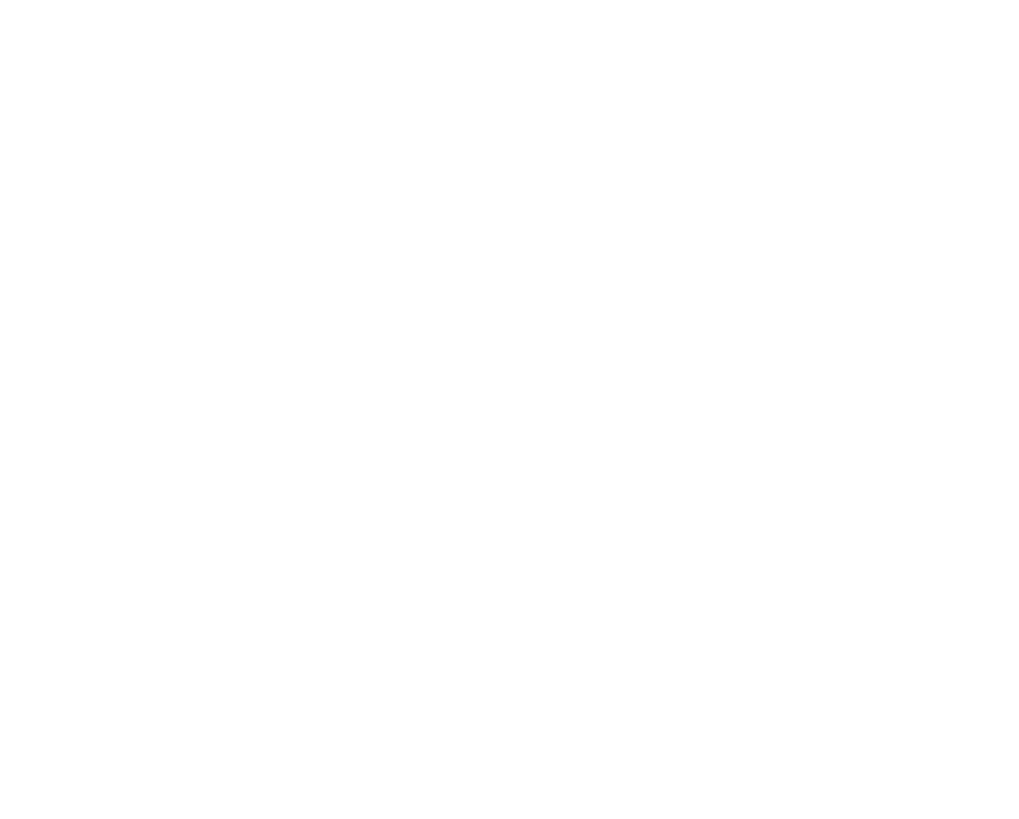

In [27]:
N_SMALL = 535 + 2

# Select clusters
small_clusters  = df["community"].value_counts().index[-N_SMALL:]

# Build subgraph of top clusters
subG = G.subgraph(small_clusters)

# Visualize
plt.figure(figsize=(10,8))
nx.draw(subG, with_labels=True, node_size=200, font_size=5)
plt.show()